## Painting Classifier by Style

### Imports

In [96]:
import seaborn as sns
import os
import matplotlib.pyplot as plt
import pandas as pd

pd.options.mode.chained_assignment = None  # default='warn'

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical

### Loading in the data

In [97]:
df = pd.read_csv("all_data_info.csv")
df

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...
103245,Jackson Pollock,1948.0,abstract,682.0,220.0,96405.0,wikiart,Action painting,Number 13A (Arabesque),train_and_test,True,25525.jpg
103246,Bernardo Strozzi,NaN,religious painting,329.0,456.0,127594.0,wikiart,Baroque,St. Francis of Assisi,train_only,True,47038.jpg
103247,Josef Sima,NaN,landscape,293.0,512.0,102519.0,wikiart,Surrealism,Maisons à la campagne II,train_and_test,False,7680.jpg
103248,Brett Whiteley,1982.0,marina,293.0,512.0,167423.0,wikiart,NaN,Thebe's Revenge,train_and_test,True,9021.jpg


### Visualizing some of the art 

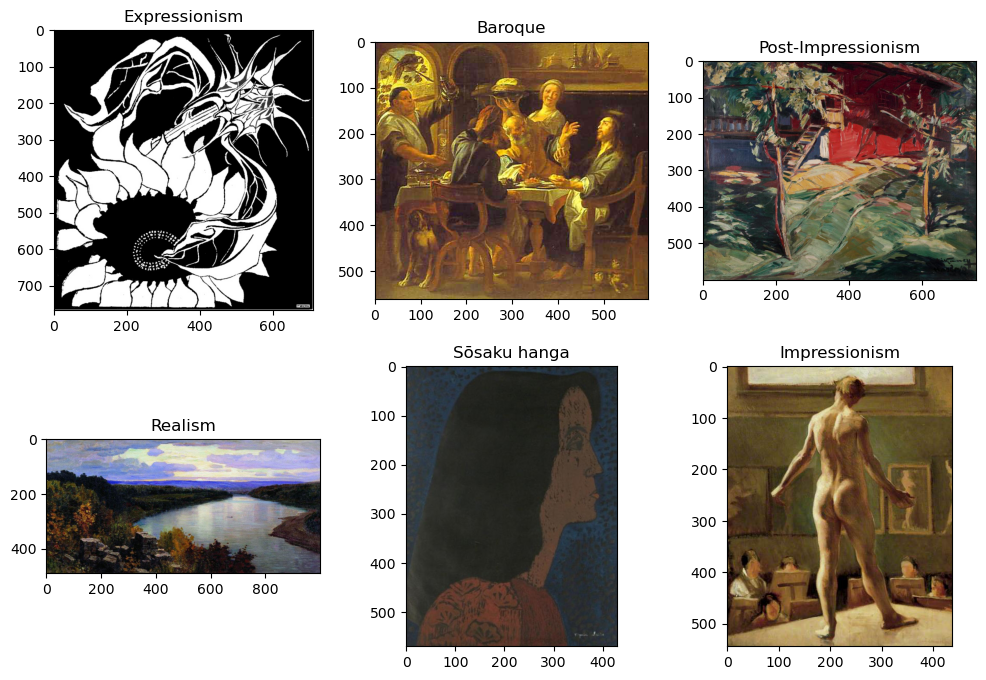

In [98]:
train_1_folder = "train_1"

# create a figure with 2 rows and 3 columns of subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# loop through the first 6 images
for i in range(6):
    # get the image path and read the image
    img_name = os.listdir(train_1_folder)[i]
    img_path = os.path.join(train_1_folder, img_name)
    img = plt.imread(img_path)
    
    # find the corresponding row in the DataFrame
    row = df[df["new_filename"] == img_name].iloc[0]
    
    # get the artist, title, and style information
    artist = row["artist"]
    title = row["title"]
    style = row["style"]
    
    # plot the image in the appropriate subplot
    row_index, col_index = divmod(i, 3)
    axs[row_index, col_index].imshow(img)
    axs[row_index, col_index].set_title(style)

# show the figure
plt.show()

### Preprocessing

It is evident we have a ton of data to work with. Let's take a deeper look into the Style column since we will be working with it extensively.

In [99]:
df["style"].value_counts()

Impressionism               10643
Realism                     10523
Romanticism                  9285
Expressionism                7013
Post-Impressionism           5778
                            ...  
Spectralism                     5
Kinetic Art                     3
Ilkhanid                        2
Renaissance                     1
Environmental (Land) Art        1
Name: style, Length: 136, dtype: int64

There is a huge imbalance in the data here. We have 5 instances of artworks that fall under the spectralism category and have more than 10,000 impressionism style paintings. We would be naive to train our model on the dataset as is. We need to filter out styles that do not have enough samples and also those that have too many. Here, the choice for the threshold is really arbitrary and we decided to work with art styles with 2,000 samples. This means that styles like realism with several thousands of paintings need to be cut down to as close to 2,000 as possible.

Text(0.5, 0, 'Number of paintings')

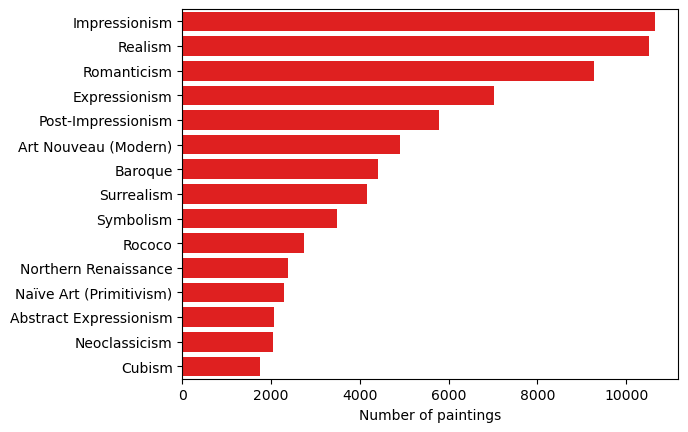

In [100]:
df["style"].value_counts()[:15]

sns.barplot(x=df["style"].value_counts()[:15].values, y=df["style"].value_counts()[:15].index,
            color="r")
plt.xlabel("Number of paintings")

Looking at the 15 most populated styles in our dataset, we see that Neoclassicism is just above our threshold with 2,038 samples. So, the next step is to cut down all samples above our threshold to meet our requirements for an unbiased dataset. To do this we will create a function to loop over the overpopulated styles, find the difference between them and the count for our Neoclassicism style, and reduce it to match our minimum limit.

In [101]:
overpop_styles = df["style"].value_counts()[:14].index.tolist()
overpop_styles

['Impressionism',
 'Realism',
 'Romanticism',
 'Expressionism',
 'Post-Impressionism',
 'Art Nouveau (Modern)',
 'Baroque',
 'Surrealism',
 'Symbolism',
 'Rococo',
 'Northern Renaissance',
 'Naïve Art (Primitivism)',
 'Abstract Expressionism',
 'Neoclassicism']

In [102]:
def style_balancer(style_arr, df):
    """
    Reduce the number of samples for each overpopulated style in the given DataFrame to match the count of the
    least represented style, and return a new DataFrame with the reduced number of samples for each style.

    Parameters:
        style_arr (list of str): A list of style names to balance.
        df (pandas.DataFrame): The DataFrame containing the samples to balance.

    Returns:
        pandas.DataFrame: A new DataFrame with the reduced number of samples for each style.

    Raises:
        None

    """

    # Get the minimum number of samples for any style in the DataFrame
    min_val = df["style"].value_counts()[13] # assuming "Neoclassicism" is at index 13

    # Initialize an empty DataFrame variable to hold the balanced samples for all styles
    empty_df_var = None

    # Loop through each style in the style_arr list
    for _style in style_arr:
        # Create a boolean mask to select only the samples with the current style
        style_mask = df["style"] == _style

        # Create a new DataFrame with only the samples with the current style
        style_df = df[style_mask]

        # Calculate the total number of samples for the current style
        tot = len(style_df.index)

        # Calculate the number of samples to remove to match the minimum count
        rmv = tot - min_val

        # Remove the excess samples from the current style DataFrame
        style_df.drop(style_df.index[range(rmv)], inplace=True)

        # Concatenate the current style DataFrame to the empty_df_var DataFrame to add it to the new DataFrame
        fin_df = pd.concat([empty_df_var, style_df], ignore_index=True)

        # Update the empty_df_var DataFrame with the new DataFrame containing the current style
        empty_df_var = fin_df

    # Return the final DataFrame containing the balanced samples for all styles
    return fin_df


df = style_balancer(overpop_styles, df)
df["style"].value_counts()


Impressionism              2038
Realism                    2038
Romanticism                2038
Expressionism              2038
Post-Impressionism         2038
Art Nouveau (Modern)       2038
Baroque                    2038
Surrealism                 2038
Symbolism                  2038
Rococo                     2038
Northern Renaissance       2038
Naïve Art (Primitivism)    2038
Abstract Expressionism     2038
Neoclassicism              2038
Name: style, dtype: int64

## TESTING SHI OUT

In [103]:
# Create an ImageDataGenerator to load and preprocess the images
#datagen = ImageDataGenerator(rescale=1./255)

# Create a flow_from_dataframe generator for the training data
#train_generator = datagen.flow_from_dataframe(
    #dataframe=df,
    #directory=train_1_folder,
    #x_col='new_filename',
    #y_col='style',
    #target_size=(256, 256),
    #batch_size=32,
    #class_mode='categorical'
#)

#train_generator.class_indices

In [104]:
def style_returner(img_name):
    for i in range(len(df)):
        if img_name == df.loc[i, "new_filename"]:
            return df.loc[i, "style"]
        
style_returner('1165.jpg')

'Impressionism'

## !!!FIX!!! WHAT IF FILE ISN'T IN TRAIN FOLDER

In [105]:
df["in_train"].value_counts()

True     21880
False     6652
Name: in_train, dtype: int64

In [110]:
#file_paths = [os.path.join(train_1_folder, f) for f in df['new_filename']]
# split data into training and testing sets
#X_train, y_train, X_test, y_test = train_test_split(file_paths, df['style'], test_size=0.2, random_state=42)

In [107]:
splitter = len(df)/2

peepee = df[:int(splitter)]

doodoo = df[int(splitter):]

peepee["style"].value_counts()

Impressionism           2038
Realism                 2038
Romanticism             2038
Expressionism           2038
Post-Impressionism      2038
Art Nouveau (Modern)    2038
Baroque                 2038
Name: style, dtype: int64

## !!!FIX!!! SHUFFLE DATA

In [9]:
df = shuffle(df)
df.reset_index(inplace=True, drop=True)

df["in_train"].value_counts()
df

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Constantin Artachino,NaN,flower painting,330.0,467.0,46518.0,wikiart,Realism,Pink Rose,train_and_test,False,9509.jpg
1,Niko Pirosmani,1905,portrait,1262.0,272.0,48426.0,wikiart,Naïve Art (Primitivism),Beauties of Ortachala (diptych),train_and_test,True,41823.jpg
2,Peter Paul Rubens,1614,religious painting,519.0,1446.0,134243.0,wikiart,Baroque,Descent from the Cross (left wing),train_and_test,False,32325.jpg
3,Nikolai Ge,1856,portrait,500.0,676.0,112706.0,wikiart,Realism,Portrait of Piotr Zabela,train_and_test,True,94829.jpg
4,Claude Lorrain,1648,pastorale,1256.0,920.0,130692.0,wikiart,Rococo,Pastoral Landscape,train_and_test,True,68747.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...
28527,Giovanni Battista Piranesi,NaN,cityscape,3893.0,2352.0,3056728.0,wikiart,Neoclassicism,Vedute di Roma,train_and_test,True,9834.jpg
28528,Mabuse,1527,religious painting,786.0,1000.0,214595.0,wikiart,Northern Renaissance,The Virgin and Child,train_only,True,45315.jpg
28529,Bernard Buffet,1981,self-portrait,343.0,550.0,81596.0,wikiart,Expressionism,Autoportrait n° 11,train_and_test,True,53945.jpg
28530,Thomas Gainsborough,c.1780,portrait,728.0,1150.0,174421.0,wikiart,Rococo,Johann Christian Fischer,train_and_test,True,5977.jpg


In [109]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

datagen = ImageDataGenerator(rescale=1./255)

# Create a flow_from_dataframe generator for the training data
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_1_folder,
    x_col='new_filename',
    y_col='style',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=train_1_folder,
    x_col='new_filename',
    y_col='style',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

train_generator.class_indices

Found 2435 validated image filenames belonging to 14 classes.
Found 605 validated image filenames belonging to 14 classes.


/opt/homebrew/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 20390 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 5102 invalid image filename(s) in x_col="new_filename". These filename(s) will be ignored.
  warnings.warn(


{'Abstract Expressionism': 0,
 'Art Nouveau (Modern)': 1,
 'Baroque': 2,
 'Expressionism': 3,
 'Impressionism': 4,
 'Naïve Art (Primitivism)': 5,
 'Neoclassicism': 6,
 'Northern Renaissance': 7,
 'Post-Impressionism': 8,
 'Realism': 9,
 'Rococo': 10,
 'Romanticism': 11,
 'Surrealism': 12,
 'Symbolism': 13}

In [111]:
# define CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(14, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [112]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)

# evaluate the model
test_loss, test_acc = model.evaluate_generator(test_generator, steps=len(test_generator))
print('Test accuracy:', test_acc)

/var/folders/k0/4b5w69j156334dt2nqbt9mfw0000gn/T/ipykernel_5028/1246936596.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10


2023-04-10 15:56:23.731445: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


77/77 [==============================] - 52s 667ms/step - loss: 3.1792 - accuracy: 0.0858 - val_loss: 2.6105 - val_accuracy: 0.1008
Epoch 2/10
77/77 [==============================] - 51s 664ms/step - loss: 2.6017 - accuracy: 0.1129 - val_loss: 2.5632 - val_accuracy: 0.1107
Epoch 3/10
77/77 [==============================] - 51s 658ms/step - loss: 2.4129 - accuracy: 0.2041 - val_loss: 2.5921 - val_accuracy: 0.1256
Epoch 4/10
77/77 [==============================] - 51s 656ms/step - loss: 1.8945 - accuracy: 0.3951 - val_loss: 2.9112 - val_accuracy: 0.1421
Epoch 5/10
77/77 [==============================] - 53s 687ms/step - loss: 1.1557 - accuracy: 0.6345 - val_loss: 3.8258 - val_accuracy: 0.1256
Epoch 6/10
77/77 [==============================] - 54s 703ms/step - loss: 0.6360 - accuracy: 0.8181 - val_loss: 5.8776 - val_accuracy: 0.1405
Epoch 7/10
77/77 [==============================] - 53s 683ms/step - loss: 0.3335 - accuracy: 0.9060 - val_loss: 7.2657 - val_accuracy: 0.1207
Epoch 8/10

/var/folders/k0/4b5w69j156334dt2nqbt9mfw0000gn/T/ipykernel_5028/1246936596.py:10: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_generator, steps=len(test_generator))


Test accuracy: 0.10247933864593506


## SHUFFLE DATA

In [1]:
#our data is currently organized by style, we want to shuffle our data so we don't have bias data
#takes a set data frame and shuffles it by style 
df = df.iloc[np.random.permutation(len(df))]

NameError: name 'df' is not defined

## STANDARDIZE IMAGES, NEED TO NORMALIZE THIS AS WELL

In [18]:
def stand_image(ary, df,img_size):
    """ 
    Takes all of the images and converts them all into the same size. 
    PIL doc
    https://pillow.readthedocs.io/en/stable/reference/Image.html
    Parameters:

    ary - our image array: train_1_folder
    dataframe - the dataframe we are using
    img_size - the size of the new image we want to convert to 
    
    Returns: 
    Pandas data frame that returns images that are all the same size
    """
    new_img_ary = np.shape(ary)

    for i in ary: 
        img_holder = PIL.Image.open(ary)
        W, H = img_holder.size
        if W>=H:
            W = img_size
            H = (H/W)*img_size
        if H<W:
            H = img_size
            W = (W/H)*img_size
        
        new_img = PIL.Image.new((img_size,img_size),(0,0,0))
        wpos = (img_size-W)/2
        hpos = (img_size-H)/2

        new_img.paste(new_img,(wpos,hpos))
        new_img_ary[i] = new_img